# Nepali Handwritten digits recognizer

### Author: Umesh Adhikari
### Author: Muhamad Iqbal  Anshori

In [2]:
# import libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, callbacks, optimizers, models

### Dataset: https://archive.ics.uci.edu/ml/datasets/Devanagari+Handwritten+Character+Dataset

### Nepali digits
<img src="nepali_digits.png" align="center"/>

## Preprocessing

In [3]:
# consider only digits
class_names = [f'digit_{i}' for i in range(10)]

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_digits_loader = train_datagen.flow_from_directory(
        'dataset/Train',
        target_size=(32, 32),
        classes = class_names,
        batch_size=32,
        color_mode = 'grayscale',
        class_mode='categorical')

test_digits_loader = test_datagen.flow_from_directory(
        'dataset/Test',
        target_size=(32, 32),
        classes = class_names,
        color_mode = 'grayscale',
        batch_size=1,
        shuffle = False,
        seed = 2076,
        class_mode='categorical')

Found 17000 images belonging to 10 classes.
Found 3000 images belonging to 10 classes.


In [6]:
def plot_image(img_path_index):
  img_path = train_digits_loader.filepaths[img_path_index]
  a = Image.open(img_path)
  arr = np.array(a)
  plt.imshow(arr,cmap= 'gray')
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

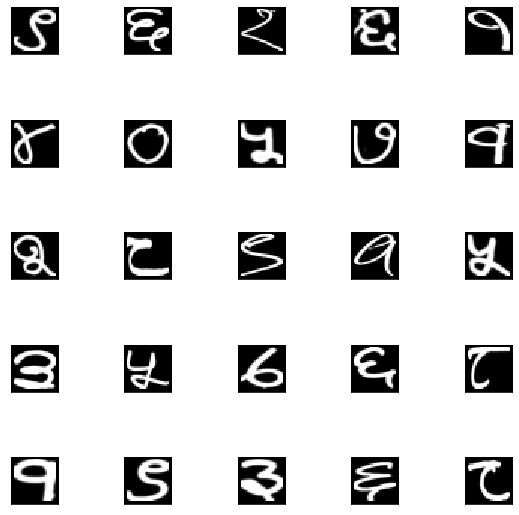

In [7]:
# plot 20 random images from our training set
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_index = random.randint(1,17000)
  plot_image(rand_index)
plt.show()

## Create a CNN model

In [8]:
def cnn_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu'))
  model.add(layers.MaxPooling2D((2,2)))
  model.add(layers.Conv2D(64,(3,3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu')) # fully conneted layer
  model.add(layers.Dropout(0.2)) # handle ovevrfitting
  model.add(layers.Dense(10, activation='softmax'))
  opt = optimizers.Adam(lr=0.0015, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [10]:
model = cnn_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

## Save the trained model  | stop training if there is no improvements

In [11]:
filepath = 'cnn_{val_acc:5.3f}.h5'
model_save = callbacks.ModelCheckpoint(filepath, monitor= 'val_acc', save_best_only=True)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [12]:
def plot_acc(history):
  plt.plot(history.epoch, history.history['val_acc'] )
  plt.plot(history.epoch, history.history['acc'])
  plt.grid(False)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Test', 'Train'])

## Train the Model

In [13]:
sample_size = train_digits_loader.n
batch_size = 32

hist = model.fit_generator(
    train_digits_loader,
    steps_per_epoch=sample_size // batch_size,
    epochs=20,
    validation_data=test_digits_loader,
    validation_steps=3000,
    callbacks=[model_save, early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
531/531 [==============================] - 10s 18ms/step - loss: 0.3009 - acc: 0.9006 - val_loss: 0.0441 - val_acc: 0.9867
Epoch 2/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0694 - acc: 0.9791 - val_loss: 0.0365 - val_acc: 0.9893
Epoch 3/20
531/531 [==============================] - 7s 12ms/step - loss: 0.0412 - acc: 0.9870 - val_loss: 0.0517 - val_acc: 0.9833
Epoch 4/20
531/531 [==============================] - 7s 12ms/step - loss: 0.0327 - acc: 0.9899 - val_loss: 0.0290 - val_acc: 0.9917
Epoch 5/20
531/531 [==============================] - 7s 12ms/step - loss: 0.0208 - acc: 0.9936 - val_loss: 0.0228 - val_acc: 0.9950
Epoch 6/20
531/531 [==============================] - 7s 13ms/step - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0232 - val_acc: 0.9947
Epoch 7/20
531/531 [==============================] - 6s 12ms/step - loss: 0.0131 - acc: 0.9965 - val_loss:

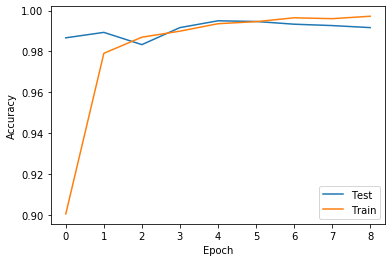

In [14]:
plot_acc(hist)

In [15]:
classifier = models.load_model('cnn_0.995.h5')

In [16]:
classifier.evaluate_generator(test_digits_loader, steps = 3000)

[0.022772070692502328, 0.995]

## Test for the test data

In [17]:
test_digits_loader.reset()
true_labels = test_digits_loader.classes
predictions_with_prob = classifier.predict_generator(test_digits_loader, steps = 3000)

In [18]:
predictions = np.argmax(predictions_with_prob, axis= 1)

## ERROR ANALYSIS

In [19]:
incorrect_predictions = np.nonzero(predictions - true_labels)

In [20]:
incorrect_predictions

(array([ 428,  752,  868,  910,  949, 1022, 1177, 1667, 1679, 1769, 1771,
        1963, 2116, 2709, 2965]),)

In [21]:
for _ in range(10):
  rand_index = random.randint(0,3000)
  print(f'True label: {true_labels[rand_index]} , Predicted labe: {predictions[rand_index]} for index {rand_index}')

True label: 7 , Predicted labe: 7 for index 2301
True label: 9 , Predicted labe: 9 for index 2961
True label: 8 , Predicted labe: 8 for index 2456
True label: 5 , Predicted labe: 5 for index 1658
True label: 0 , Predicted labe: 0 for index 149
True label: 1 , Predicted labe: 1 for index 450
True label: 5 , Predicted labe: 5 for index 1575
True label: 4 , Predicted labe: 4 for index 1489
True label: 2 , Predicted labe: 2 for index 850
True label: 2 , Predicted labe: 2 for index 870


In [22]:
# function to plot image with predictions percentages
def plot_predicted_image(i, predictions_array, true_labels, img_generator):
  predicted_label, true_label, img = predictions_array[i], true_labels[i], img_generator[i][0]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  reshaped_img = img.reshape(32,32)
  plt.imshow(reshaped_img, cmap=plt.cm.binary)
  plt.title(f' Predicted {true_label } for {predicted_label}  digit')

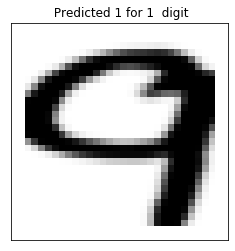

In [23]:
plot_predicted_image(500, predictions, true_labels, test_digits_loader)

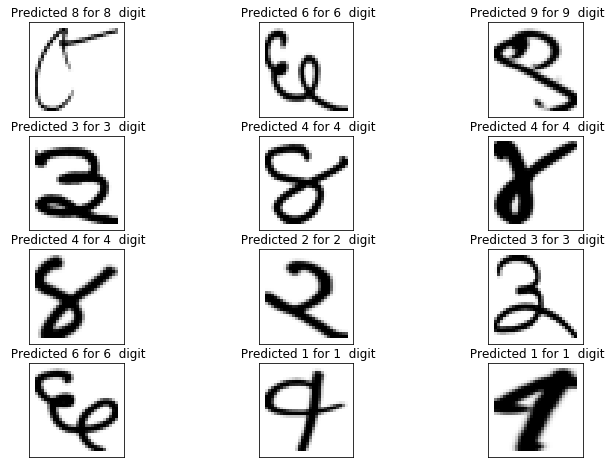

In [24]:
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  rand_idx = random.randint(0,3000)
  plot_predicted_image(rand_idx, predictions, true_labels, test_digits_loader)
plt.show()

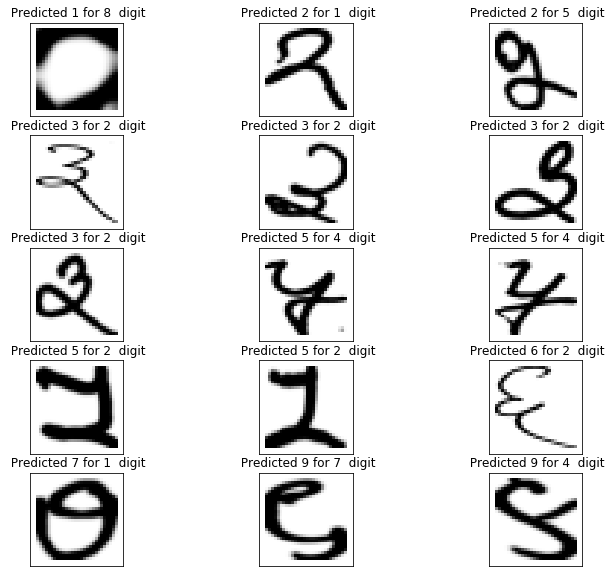

In [25]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 *num_cols, 2*i + 1)
  plot_predicted_image(incorrect_predictions[0][i], predictions, true_labels, test_digits_loader)
plt.show()

## Due to some mislable we get the incorrect prediction. 

## To get cent percent accurate prediction we need to clean the dataset and label correctly which are misslabled.